# Imports

In [455]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import classification_report, confusion_matrix

# Web Scraping

In [ ]:
# let's scrape all of the products in the "snacks and confectionary" section of the Woolworths online website
# let's scrape the item name, energy, saturated fat, sodium and sugars (per 100g)

basic_url = 'https://www.woolworths.com.au/shop/browse/pantry/snacks-confectionery?pageNumber='

data = []

for i in range(1, 62):
    url = basic_url + str(i)
    
    # create a new Firefox session
    driver = webdriver.Chrome("/Users/Tazman/Desktop/chromedriver")
    driver.implicitly_wait(30)
    driver.get(url)
    
    soup=BeautifulSoup(driver.page_source, 'lxml')   
    
    urls = []
    for a_tag in soup.find_all('a', {"class":"shelfProductTile-imageWrapper"}):
        temp_url = 'https://www.woolworths.com.au' + str(a_tag.get('href'))
        urls.append(temp_url)
            
    
    for i in range(0, 42):
        try:
            dictionary = {}

            driver.get(urls[i])
            new_soup=BeautifulSoup(driver.page_source, 'lxml')

            dictionary['Item'] = new_soup.find('h1').text

            if new_soup.find_all('td') == []:
                dictionary['Energy'] = 'NA'
            else:
                dictionary['Energy'] = new_soup.find_all('td')[2].text
                dictionary['Sat Fat'] = new_soup.find_all('td')[11].text
                dictionary['Sugars'] = new_soup.find_all('td')[17].text
                dictionary['Sodium'] = new_soup.find_all('td')[20].text
            
            data.append(dictionary)
        except:
            dictionary = {}
            dictionary['Item'] = 'NA'
            dictionary['Energy'] = 'NA'
            dictionary['Sat Fat'] = 'NA'
            dictionary['Sugars'] = 'NA'
            dictionary['Sodium'] = 'NA'
            data.append(dictionary)
     
    
df = pd.DataFrame(data)

# Cleaning

In [ ]:
# let's drop all the rows that have null values
df.dropna(inplace=True)

In [699]:
#let's drop all the rows that have 'NA' values
df = df[(df['Energy'] != 'NA') & (df['Item'] != 'NA') & (df['Sat Fat'] != 'NA') & 
  (df['Sodium'] != 'NA') & (df['Sugars'] != 'NA')]

df.head()

,Energy,Item,Sat Fat,Sodium,Sugars
54,2030kJ,\n Oreo Original Grab 'n Go...,9.8g,514mg,37.9g
55,2450kJ,\n Lindt Nocciolatte Bag 96...,15.0g,74mg,45.0g
62,1070kJ,\n Double D Fruit Drops Sug...,0g,0.3mg,0.2g
63,2170kJ,\n Arnott's Tim Tam Chocola...,15.1g,161mg,44.9g
64,Approx. 2270kJ,\n Cheezels Cheese Box 125...,Approx. 15.8g,Approx. 1200mg,Approx. 4.6g


In [700]:
# let's drop all the duplicates (based on name)
df = df.drop_duplicates(subset='Item', keep="first")
df.head(30)

,Energy,Item,Sat Fat,Sodium,Sugars
54,2030kJ,\n Oreo Original Grab 'n Go...,9.8g,514mg,37.9g
55,2450kJ,\n Lindt Nocciolatte Bag 96...,15.0g,74mg,45.0g
62,1070kJ,\n Double D Fruit Drops Sug...,0g,0.3mg,0.2g
63,2170kJ,\n Arnott's Tim Tam Chocola...,15.1g,161mg,44.9g
64,Approx. 2270kJ,\n Cheezels Cheese Box 125...,Approx. 15.8g,Approx. 1200mg,Approx. 4.6g
65,Approx. 2090kJ,\n Kettle Sea Salt Chips 1...,Approx. 2.6g,Approx. 486mg,Approx. 0g
66,2190kJ,\n Arnott's Tim Tam Choc Do...,16.0g,144mg,47.3g
67,2000kJ,\n Cadbury Cherry Ripe 52g...,20.0g,25mg,48.0g
68,Approx. 2060kJ,\n Kettle Chips Soy Chicken...,Approx. 2.4g,Approx. 514mg,Approx. 3.4g
69,Approx. 2020kJ,\n Kettle Sea Salt & Vinega...,Approx. 2.4g,Approx. 807mg,Approx. 1.6g


In [701]:
df.shape

(548, 5)

## Cleaning the 'Sugars' column

In [703]:
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace('Approx.', ''))
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace('g', ''))
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace('<1.0', '1.0'))
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace('<1', '1'))

In [704]:
df = df[df['Sugars'] != "Smith's Oriinal Crinkle Cut Potato Chips:1.7, Salt & Vinear Flavoured Crinkle Cut Potato Chips: 3.6, Barbecue Flavoured Crinkle Cut Potato Chips: 4.0, Chicken Flavoured Crinkle Cut Potato Chips: 3.3"]

In [705]:
df = df[df['Sugars'] != "Smith's Oriinal Crinkle Cut Potato Chips:1.0, Smith's Salt Vinear Flavoured Crinkle Cut Potato Chips: 3.0, Twisties Cheese Flavoured Snacks: 5.8, Cheetos Cheese & Bacon Flavoured Snacks: 3.6, Burer Rins Burer Flavoured Snacks: 2.3"]

In [706]:
df = df[df['Sugars'] != "Twisties Cheese:5.8, Twisties Chicken: 2.5, Cheetos Cheese & Bacon: 3.6, Burer Rins: 2.3."]

In [715]:
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace('%', ''))
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace('m', ''))
df['Sugars'] = df['Sugars'].apply(lambda x: x.replace(',', '.'))

In [717]:
df['Sugars'] = df['Sugars'].astype(float)

## Cleaning the 'Sodium' column

In [736]:
df['Sodium'] = df['Sodium'].apply(lambda x: x.replace('Approx.', ''))
df['Sodium'] = df['Sodium'].apply(lambda x: x.replace('mg', ''))
df['Sodium'] = df['Sodium'].apply(lambda x: x.replace('m', ''))
df['Sodium'] = df['Sodium'].apply(lambda x: x.replace('g', ''))
df['Sodium'] = df['Sodium'].apply(lambda x: x.replace('0.4g / 400', '0.1'))
df['Sodium'] = df['Sodium'].apply(lambda x: x.replace('<', ''))

In [738]:
df['Sodium'] = df['Sodium'].astype(float)

## Cleaning the 'Sat Fat' column

In [745]:
df['Sat Fat'] = df['Sat Fat'].apply(lambda x: x.replace('Approx.', ''))
df['Sat Fat'] = df['Sat Fat'].apply(lambda x: x.replace('g', ''))
df['Sat Fat'] = df['Sat Fat'].apply(lambda x: x.replace('<', ''))
df['Sat Fat'] = df['Sat Fat'].apply(lambda x: x.replace('m', ''))

In [747]:
df['Sat Fat'] = df['Sat Fat'].astype(float)

## Cleaning the 'Energy' column

In [754]:
df['Energy'] = df['Energy'].apply(lambda x: x.replace('Approx.', ''))
df['Energy'] = df['Energy'].apply(lambda x: x.replace('kJ', ''))
df['Energy'] = df['Energy'].apply(lambda x: x.replace('kj', ''))
df['Energy'] = df['Energy'].apply(lambda x: x.replace('g', ''))

In [756]:
df['Energy'] = df['Energy'].astype(float)

## Cleaning the 'Item' column

In [760]:
df.reset_index(inplace=True)

In [56]:
df['Item'] = df['Item'].apply(lambda x: x.replace('\n                    ', ''))
df['Item'] = df['Item'].apply(lambda x: x.replace('\n                ', ''))
df['Item'] = df['Item'].apply(lambda x: x.replace('  ', ' '))


In [786]:
df.drop(columns = 'index', inplace=True)

In [789]:
# Finally, let's rearrange the column order
df = df[['Item', 'Energy', 'Sat Fat', 'Sugars', 'Sodium']]

## Cleaning by exploring the extremes

In [2]:
# let's explore the foods with the lowest energy
#df.sort_values(by='Energy').

In [802]:
# cleaning: Arnott's Lemon Crisp 250g should have Energy 2170kJ
df.loc[155,'Energy'] = 2170

# cleaning: 180 Degrees Oat Crackers Hazelnut 150g Energy 2170kJ
df.loc[361,'Energy'] = 2050

In [3]:
# let's explore the foods with the highest energy
#df.sort_values(by='Energy', ascending=False)

In [805]:
# cleaning: Nutri Grain Nuts & Bolts Trail Mix Original 120g should have Energy 2000kJ
df.loc[478,'Energy'] = 2000

In [5]:
# let's explore the foods with the highest sodium
#df.sort_values(by='Sodium', ascending=False)

In [843]:
# cleaning: 180 Degrees Oat Crackers Hazelnut 150g should have Sodium 811
df.loc[361,'Sodium'] = 811

In [845]:
#finally, let's rename the columns
df.columns = ['Item', 'Energy (kJ)', 'Sat Fat (g)', 'Sugars (mg)', 'Sodium (g)']

## Going back and retrieved health star info

In [278]:
HSR_dic = {}

HSR_dic['Woolworths Pistachios 80g'] = 5
HSR_dic['Woolworths Roasted & Salted Mixed Nuts 80g'] = 4
HSR_dic['Woolworths Muesli Bar Choc Chip 8 pack'] = 3
HSR_dic["Carman's Classic Fruit & Nut Muesli Bars 6 pack"] = 3.5
HSR_dic['Barley + Seven Seeds Bars Seeds Bars 6 pack'] = 5
HSR_dic['Barley + Cranberry And Almond Bars Almond Bars 6 pack'] = 5
HSR_dic["Carman's Dark Choc Cranberry & Almond Muesli Bars 6 pack"] = 2.5
HSR_dic['Uncle Tobys Muesli Bars Yoghurt & Mango & Passionfruit 6 pack'] = 4
HSR_dic['Uncle Tobys Muesli Bars Chewy Choc Chip 6 pack'] = 4
HSR_dic["Carman's Original Fruit Free Muesli Bars 6 pack"] = 4
HSR_dic['Nestle Milo Dipped Snack Bars 6 pack'] = 3
HSR_dic["Carman's Dark Choc Blueberry Superfood Bars 6 pack"] = 3
HSR_dic["Carman's Classic Fruit & Nut Muesli Bars 6 pack"] = 4
HSR_dic["Carman's Super Berry Muesli Bars 6 pack"] = 4
HSR_dic['Uncle Tobys Muesli Bars Chewy White Choc Chip 6 pack'] = 4
HSR_dic['Uncle Tobys Muesli Bars Chewy Apricot 6 pack'] = 4.5
HSR_dic['Woolworths Microwave Popcorn Butter Flavoured 100g'] = 2.5
HSR_dic['Uncle Tobys Muesli Bars Chewy Forest Fruits 6 pack'] = 4.5
HSR_dic['Woolworths Beef Jerky Original 180g'] = 1
HSR_dic['Macro Fruit & Nut Energy Mix 500g'] = 4
HSR_dic['Macro Seeds Nibble Mix Roasted 500g'] = 5
HSR_dic['Macro Nuts & Berry Boost Mix 500g'] = 4
HSR_dic['Macro Organic Turkish Figs Figs 500g'] = 4.5
HSR_dic['Woolworths Salted Beer Nuts Beer Nuts 500g'] = 4
HSR_dic['Woolworths Cashews 450g'] = 4.5
HSR_dic['Woolworths Almond Meal 150g'] = 5
HSR_dic['Smiths Chips Salt & Vinegar 60g'] = 2
HSR_dic["Smith's Share Pack Crinkle Cut Original 170g"] = 2.5
HSR_dic['Macro Organic Trail Mix 250g'] = 4.5
HSR_dic['Macro Organic Brazil Nuts Brazil Nuts 250g'] = 4
HSR_dic['Woolworths Salted Pistachios 250g'] = 4.5
HSR_dic['Woolworths Scotch Fingers 250g'] = 1.5
HSR_dic['Essentials Assorted Flavours Fruit Bars 25 pack'] = 1.5
HSR_dic['Woolworths Muesli Bars Yoghurt & Strawberry 248g 8pk'] = 3
HSR_dic['Woolworths Chips Crinkle Cut Original 175g'] = 1
HSR_dic['Macro Air Popped Popcorn Salted & Sweet 20g'] = 4
HSR_dic['Thinkfood Mini Munch Almond Blueberry 20g'] = 5
HSR_dic['Lucky Pine Nuts Natural Seed Mix 200g'] = 5
HSR_dic['Woolworths Choccy Caramels 200g'] = 0.5
HSR_dic['Woolworths Chocolate Fingers Biscuit 200g'] = 0.5
HSR_dic['Woolworths Choccy Slams 200g'] = 0.5
HSR_dic['Woolworths Choccy Wheats 200g'] = 1
HSR_dic['Unibic Shortbread Shortbread Fingers 200g'] = 0.5
HSR_dic['Woolworths Shortbread Fingers 200g'] = 0.5
HSR_dic['Woolworths Raspberry Tartlets 200g'] = 1.5
HSR_dic['Woolworths Hundreds & Thousands Biscuits 200g'] = 0.5
HSR_dic['Woolworths Milk Bottles 200g'] = 2
HSR_dic['Woolworths 3d Gummy Bears 200g'] = 1.5
HSR_dic['Woolworths 3d Gummy Blocks 200g'] = 1.5
HSR_dic['Woolworths Muesli Bars Choc Drizzle 185g'] = 3
HSR_dic['Uncle Tobys Muesli Bars Yoghurt & Honeycomb 185g'] = 4
HSR_dic['Woolworths Muesli Bars Apricot Yoghurt 185g'] = 3
HSR_dic['Riverside Pecan Halves 180g'] = 4.5
HSR_dic['Woolworths Beef Jerky Original 180g'] = 1
HSR_dic["Arnott's Shapes Cheese & Bacon 180g"] = 2
HSR_dic['Woolworths Chips Crinkle Cut Roast Chicken 175g'] = 1
HSR_dic["Arnott's Shapes Chicken Crimpy 175g"] = 2
HSR_dic["Arnott's Shapes Cheddar 175g"] = 1.5
HSR_dic["Arnott's Shapes Original Bbq 175g"] = 2
HSR_dic["Uncle Toby's Milk & Oats Chocolate 175g"] = 4
HSR_dic["Uncle Toby's Milk & Oats Strawberry 175g"] = 4
HSR_dic["Uncle Toby's Milk & Oats Vanilla 175g"] = 4
HSR_dic['Woolworths Rosemary Wheaten Crackers Rosemary 170g'] = 2
HSR_dic['Woolworths Glazed Mints 170g'] = 0.5
HSR_dic['Woolworths Roasted & Salted Pistachios 170g'] = 4.5
HSR_dic['Woolworths Bananas 170g'] = 1
HSR_dic['Tyrrells Chips Lightly Salted 165g bag'] = 3.5
HSR_dic["Arnott's Tim Tam White 165g"] = 0.5
HSR_dic['Woolworths Sour Cream & Onion Stacked Chips 160g'] = 1.5
HSR_dic['Woolworths Original Flavour Stacked Chips 160g'] = 1.5
HSR_dic["Arnott's Shapes Nacho Cheese 160g"] = 2.5
HSR_dic['Woolworths Cashews 150g'] = 4.5
HSR_dic['Woolworths Almond Meal 150g'] = 5
HSR_dic['Woolworths Brazil Nuts 150g'] = 4
HSR_dic['Woolworths Hazelnuts 150g'] = 5
HSR_dic['Smiths Southern Fried Chicken 150g'] = 3
HSR_dic['Sunrice Multigrain Thin Rice Cake 150g'] = 4
HSR_dic['Woolworths Onion & Chives Puff Pastry Twists 150g'] = 0.5
HSR_dic['Woolworths Cheddar Cheese Puff Pastry Twists 150g'] = 0.5
HSR_dic['Sunrice Thick Rice Cakes 150g'] = 4
HSR_dic['Sunrice Rice Cakes Original Rice Cakes 150g'] = 4
HSR_dic['Sunrice Rice & Quinoa 150g'] = 4
HSR_dic['Woolworths Thin Brown Rice Cakes Original 150g'] = 4
HSR_dic['Woolworths Walnuts 150g 150g'] = 4
HSR_dic['Woolworths Cashews Dry Roasted 150g'] = 4.5
HSR_dic['Woolworths Snack Pot Nut Mix Cheeseburger Style 150g'] = 2.5
HSR_dic['Woolworths Coconut Cream Biscuits 150g'] = 1
HSR_dic['Woolworths Chocolate Cream Biscuits 150g'] = 1
HSR_dic['Woolworths Snakes 150g'] = 2
HSR_dic['Woolworths Eucalyptus Drops 150g'] = 1.5
HSR_dic['Woolworths Eucalyptus & Honey Drops 150g'] = 1.5
HSR_dic['Woolworths Party Mix 150g'] = 1.5
HSR_dic['Uncle Tobys Muesli Bars Variety Pack 15 pack'] = 4
HSR_dic['Uncle Tobys Muesli Bars Aussie Favourites Multipack 15 pack'] = 4
HSR_dic['Uncle Tobys Muesli Bars Lunch Box Favourites 15 pack'] = 4
HSR_dic['Uncle Tobys Muesli Bars Choc Chip 15 pack'] = 4
HSR_dic['Thinkfood Munch Pumpkin Seed 140g'] = 4.5
HSR_dic['Thinkfood Munch Almond Trail 140g'] = 4.5
HSR_dic['Thinkfood Munch Roasted Almond 140g'] = 5
HSR_dic['Thinkfood Munch Hemp Seed Blueberry 140g'] = 4.5
HSR_dic['Thinkfood Munch Flax Sesame Sunflower 140g'] = 4.5
HSR_dic['Woolworths Cracked Pepper Water Crackers 125g'] = 2
HSR_dic["Arnott's Cruskits Original 125g"] = 3.5
HSR_dic["Arnott's Cruskits 98% Fat Free 125g"] = 4
HSR_dic['Woolworths Thin Rice Cakes Sour Cream & Chives 125g'] = 3
HSR_dic['Woolworths Chocolate Creme Wafers 125g'] = 1
HSR_dic['Woolworths Vanilla Creme Wafers 125g'] = 1
HSR_dic['Woolworths Strawberry Creme Wafers 125g'] = 1
HSR_dic['Woolworths Almonds Slivered 120g'] = 5
HSR_dic['Woolworths Almonds Flaked 120g'] = 5
HSR_dic['Woolworths Roasted & Salted Macadamias 120g'] = 3
HSR_dic['Woolworths Honey Macadamia 120g'] = 1.5
HSR_dic['Nobbys Loaded Nacho Cheese Nacho Cheese 110g'] = 1.5
HSR_dic['Nobbys Loaded Buffalo Wings Buffalo Wings 110g'] = 1.5
HSR_dic['Woolworths Hazelnut Kernels 110g'] = 5
HSR_dic['Woolworths Sesame & Cracked Pepper Wafer Crackers 100g'] = 3
HSR_dic['Woolworths Original Wafer Crackers 100g'] = 2.5
HSR_dic['Woolworths Original Rice Crackers 100g'] = 3
HSR_dic['Woolworths Rice Cracker Seaweed 100g'] = 3
HSR_dic['Woolworths Sea Salt Brown Rice Crackers 100g'] = 3.5
HSR_dic['Woolworths Tangy Bbq Rice Crackers 100g'] = 3
HSR_dic['Woolworths Multigrain Brown Rice Crackers 100g'] = 4
HSR_dic['Woolworths Crinkle Cut Rice Crackers Bbq 100g'] = 3
HSR_dic['Woolworths Sesame Seeds 100g'] = 5
HSR_dic['Woolworths Pinenuts 100g'] = 5
HSR_dic['Woolworths Original Gluten Free Popcorn 10 pack'] = 4

In [305]:
def health_star(item):
    if item in list(HSR_dic.keys()):
        return HSR_dic[item]
    else:
        return np.NaN

In [306]:
health_star("Carman's Supe Berry Muesli Bars 6 pack")

nan

In [309]:
df['HSR'] = df['Item'].apply(health_star)

In [315]:
df.drop(columns = 'Unnamed: 0', inplace=True)

In [323]:
df = df.sort_values(by='HSR', ascending=False).reset_index(drop=True)

In [336]:
df.to_csv('df_absolute_final')

# Exploratory Data Analysis

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 6 columns):
Item           545 non-null object
Energy (kJ)    545 non-null float64
Sat Fat (g)    545 non-null float64
Sugars (mg)    545 non-null float64
Sodium (g)     545 non-null float64
HSR            123 non-null float64
dtypes: float64(5), object(1)
memory usage: 25.6+ KB


In [335]:
df.head()

,Item,Energy (kJ),Sat Fat (g),Sugars (mg),Sodium (g),HSR
0,Woolworths Pinenuts 100g,2710.0,4.3,3.6,12.0,5.0
1,Macro Seeds Nibble Mix Roasted 500g,2100.0,4.1,23.1,5.0,5.0
2,Woolworths Hazelnuts 150g,2690.0,2.7,4.4,5.0,5.0
3,Woolworths Pistachios 80g,2390.0,5.8,5.9,7.0,5.0
4,Thinkfood Munch Roasted Almond 140g,2190.0,2.6,11.4,133.0,5.0


## Univariate Analysis

In [341]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Energy (kJ),545.0,1972.992661,366.069128,288.0,1740.0,2030.0,2200.0,3080.0
Sat Fat (g),545.0,8.754532,8.114261,0.0,2.3,6.5,13.8,62.4
Sugars (mg),545.0,25.908202,22.334474,0.0,3.5,23.4,45.0,97.4
Sodium (g),545.0,285.323853,293.076787,0.0,55.0,166.0,479.0,1790.0
HSR,123.0,3.028455,1.464471,0.5,1.5,3.0,4.0,5.0


/Users/Tazman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


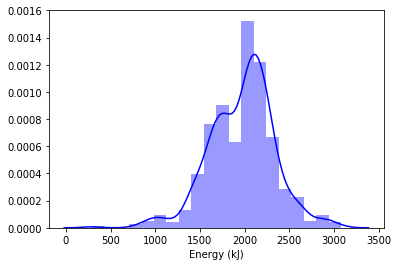

In [354]:
sns.distplot(df['Energy (kJ)'],kde=True,bins=20,color='b');

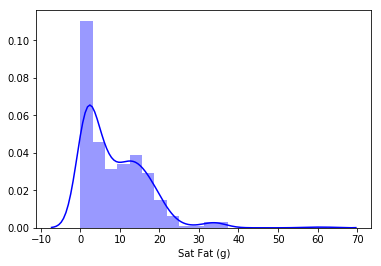

In [355]:
sns.distplot(df['Sat Fat (g)'],kde=True,bins=20,color='b');

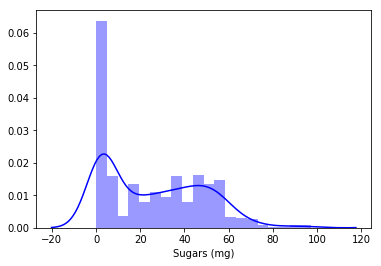

In [359]:
sns.distplot(df['Sugars (mg)'],kde=True,bins=20,color='b');

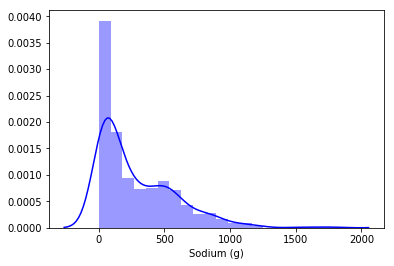

In [360]:
sns.distplot(df['Sodium (g)'],kde=True,bins=20,color='b');

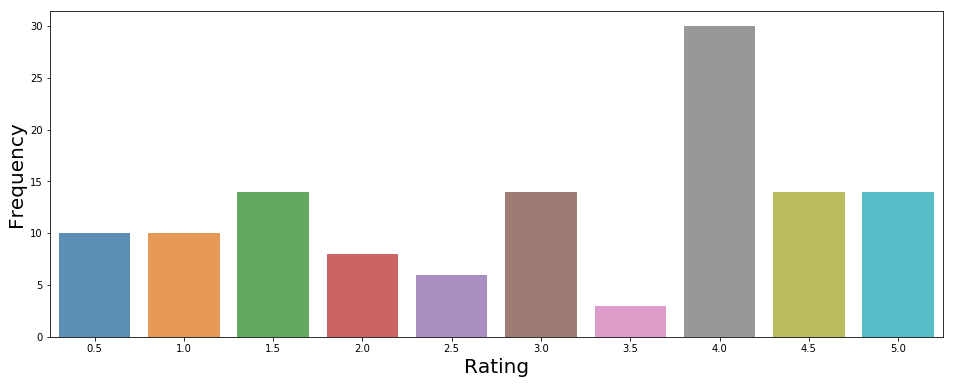

In [371]:
newyorkTimezone = df['HSR'].value_counts()
plt.figure(figsize=(16, 6))
ax = sns.barplot(newyorkTimezone.index, newyorkTimezone.values, alpha=0.8)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Rating', fontsize=20)
plt.show()

## Multivariate Analysis

/Users/Tazman/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


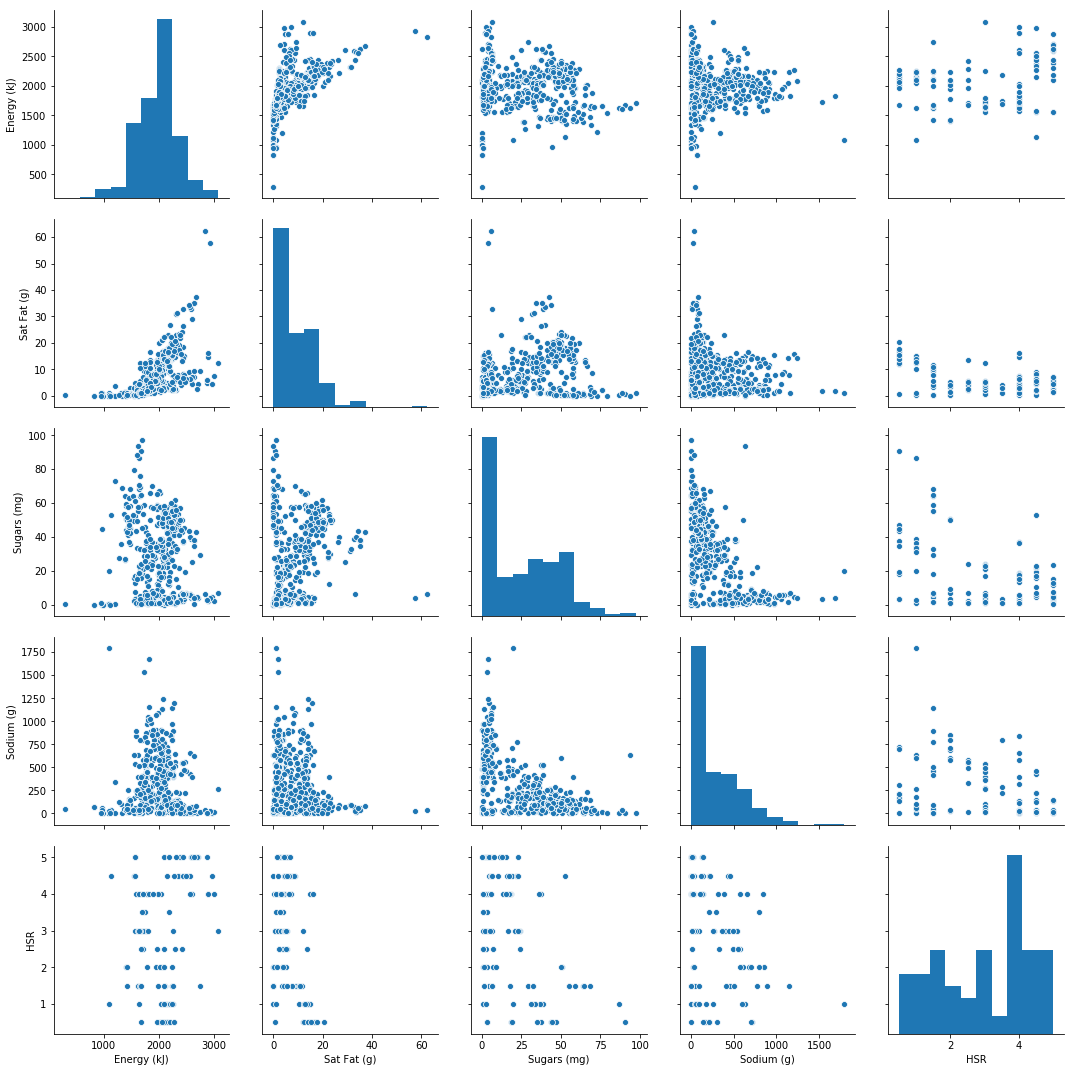

In [372]:
sns.pairplot(df, size=3);

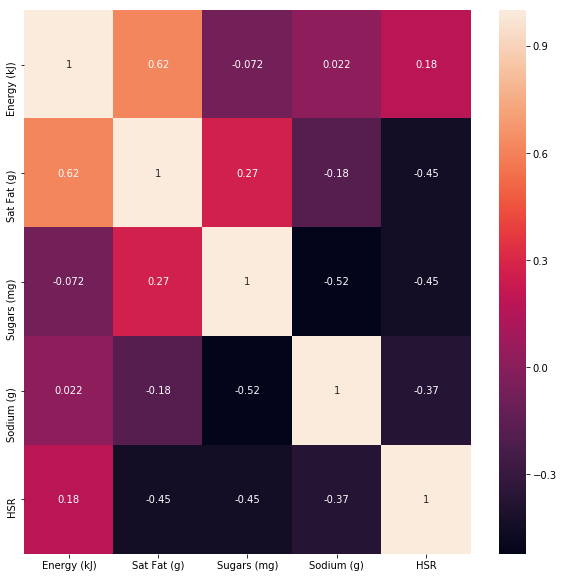

In [514]:
#let's create a heatmap to see the correlations between different variables.
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True);

/Users/Tazman/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


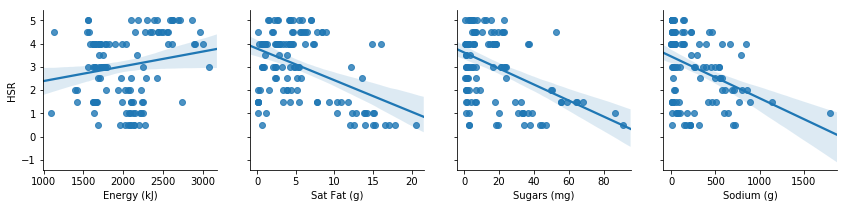

In [374]:
#let's construct pairplots for the interesting variables
sns.pairplot(df, 
             x_vars=['Energy (kJ)', 'Sat Fat (g)','Sugars (mg)','Sodium (g)'],
             y_vars=['HSR'],size=3,kind='reg');

# Preprocessing

In [382]:
X = df[df['HSR'] > 0][['Energy (kJ)', 'Sat Fat (g)', 'Sugars (mg)', 'Sodium (g)']]

In [470]:
y = df[df['HSR'] > 0][['HSR']].astype(str)

In [471]:
ss = StandardScaler()

Xs = ss.fit_transform(X)

In [472]:
# prepare the train and test splits
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state = 42, stratify=y)

In [473]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(82, 4)
(41, 4)
(82, 1)
(41, 1)


In [490]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 122
Data columns (total 4 columns):
Energy (kJ)    123 non-null float64
Sat Fat (g)    123 non-null float64
Sugars (mg)    123 non-null float64
Sodium (g)     123 non-null float64
dtypes: float64(4)
memory usage: 4.8 KB


In [491]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 122
Data columns (total 1 columns):
HSR    123 non-null object
dtypes: object(1)
memory usage: 1.9+ KB


# Modelling

In [474]:
# determine the baseline accuracy (this is the accuracy that a model needs to outperform to be meaningful)
y['HSR'].value_counts(normalize=True)*100

4.0    24.390244
1.5    11.382114
5.0    11.382114
3.0    11.382114
4.5    11.382114
0.5     8.130081
1.0     8.130081
2.0     6.504065
2.5     4.878049
3.5     2.439024
Name: HSR, dtype: float64

So the model needs to outperform 24%

In [528]:
# define functions to evaluate the model


class_names = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
  #  if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #      print("Normalized confusion matrix")
  #  else:
  #      print('Confusion matrix, without normalization')

 #   print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)



def print_cm_cr(y_test, y_pred):
    """prints the confusion matrix and the classification report"""
    #confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    #print(confusion)
    print()
    print(classification_report(y_test, y_pred))

In [578]:
#first model - logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.45121951219512196
0.34146341463414637


/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


AxesSubplot(0.025,0.174253;0.76x0.732692)

              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         4
         1.5       0.60      0.43      0.50         7
         2.0       0.33      0.50      0.40         2
         2.5       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         3
         3.5       0.00      0.00      0.00         0
         4.0       0.70      0.47      0.56        15
         4.5       0.00      0.00      0.00         0
         5.0       0.60      0.33      0.43         9

   micro avg       0.34      0.34      0.34        41
   macro avg       0.22      0.17      0.19        41
weighted avg       0.51      0.34      0.40        41

None


/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


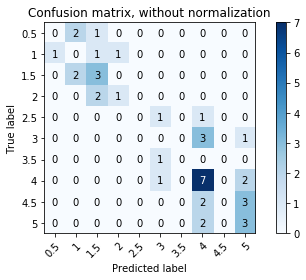

In [603]:
print(plot_confusion_matrix(y_test, lr.predict(X_test), classes=class_names,
                      title='Confusion matrix, without normalization'))
print(print_cm_cr(lr.predict(X_test), y_test))

In [650]:
#second model - knn
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.7804878048780488
0.5365853658536586


/Users/Tazman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


AxesSubplot(0.025,0.174253;0.76x0.732692)

              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00         0
         1.0       0.33      0.20      0.25         5
         1.5       0.60      0.43      0.50         7
         2.0       1.00      0.60      0.75         5
         2.5       0.00      0.00      0.00         2
         3.0       0.75      0.60      0.67         5
         3.5       0.00      0.00      0.00         0
         4.0       0.70      0.78      0.74         9
         4.5       0.40      0.50      0.44         4
         5.0       0.60      0.75      0.67         4

   micro avg       0.54      0.54      0.54        41
   macro avg       0.44      0.39      0.40        41
weighted avg       0.61      0.54      0.56        41

None


/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Tazman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


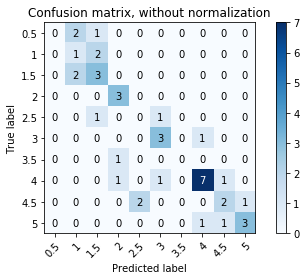

In [651]:
print(plot_confusion_matrix(y_test, knn.predict(X_test), classes=class_names,
                      title='Confusion matrix, without normalization'))
print(print_cm_cr(knn.predict(X_test), y_test))

In [661]:
results = pd.DataFrame()
results['predicted'] = knn.predict(X_test)
results['predicted'] = results['predicted'].astype(float)

results['actual'] = y_test['HSR'].values
results['actual'] = results['actual'].astype(float)

results['difference'] = np.abs(results['predicted'] - results['actual'])

In [663]:
results = results.sort_values(by='difference')

In [667]:
results['difference'].value_counts(normalize=True)*100

0.0    53.658537
0.5    24.390244
1.0    12.195122
2.0     7.317073
1.5     2.439024
Name: difference, dtype: float64

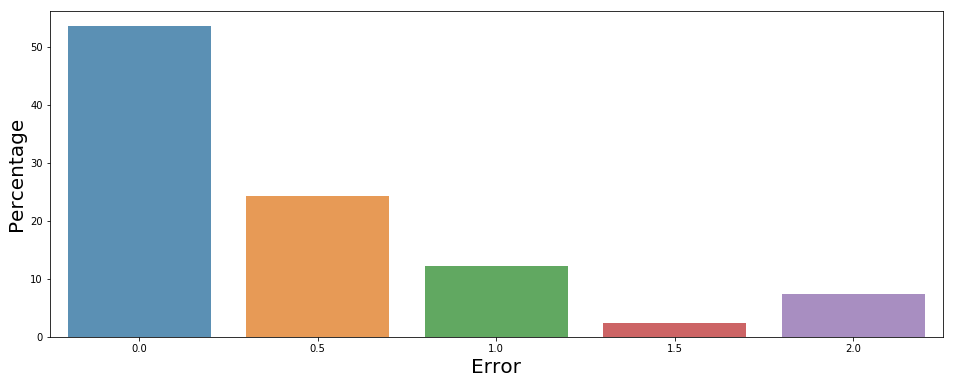

In [671]:
newyorkTimezone = results['difference'].value_counts(normalize=True)*100
plt.figure(figsize=(16, 6))
ax = sns.barplot(newyorkTimezone.index, newyorkTimezone.values, alpha=0.8)
plt.ylabel('Percentage', fontsize=20)
plt.xlabel('Error', fontsize=20)
plt.show()